<div align="center">



# Deep Generative Models
## Computer Engineering Department
### Homework 2: Autoregressive models
#### Alireza Sabounchi
sabounchial@gmail.com

</div>


### Full Name : Amir Mohammad Babaei
### Student Number : 402212399


# Introduction
## What is an Autoregressive Generative Model?
Autoregressive generative models are a type of generative model that generates new data samples by learning the probability distribution of the training data. The generated samples should look like the training set but also be unique. For example, they can generate new faces, new designs for objects, etc.

## Mathematical Description
The mathematical foundation of autoregressive models is based on the chain rule of probability. We can factorize the joint distribution over the n-dimensions as:

$$p(x) = \prod_{i=1}^{n} p(x_i | x_1, x_2, …, x_{i-1}) = \prod_{i=1}^{n} p(x_i | x_{<i})$$

where $x_{<i} = [x_1, x_2, …, x_{i-1}]$ denotes the vector of random variables with index less than i.

## Applications of Autoregressive Generative Models
Autoregressive models have a wide range of applications, including:

1. **Image Generation**: They can generate new images according to a set of training examples.
2. **Inference from Partial Images**: They can take a partially obscured image and infer what should be in the blank areas.
3. **Weather Forecasting**: They can estimate future weather parameters like temperature, pressure, or wind speed.
4. **Signal Processing**: In engineering, AR models help in analyzing and forecasting signal behavior.
5. **Economic Forecasting**: They can predict future economic indicators such as GDP growth, inflation rates, or **stock prices**.

### **The Model**
In this exercise, we will explore the application of Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. LSTMs are particularly suited for this task due to their ability to capture long-term dependencies in time series data.

We will treat this as an autoregressive problem, where we use past stock prices to predict future ones. Autoregressive models are widely used in time series forecasting, and they can capture complex patterns in the data.

The goal of this exercise is to familiarize you with the process of training an LSTM network and using it for prediction. You will learn how to preprocess time series data, visualize it, construct an LSTM model, train it on historical stock price data, and evaluate its performance.
<div align="center">

![httpsen.wikipedia.orgwikiLong_short-term_memory.png](attachment:httpsen.wikipedia.orgwikiLong_short-term_memory.png)
#### Figure 1: LSTM Schema (Source: Wikipedia)
</div>

### **The Dataset**
Our primary data source will be Yahoo Finance, a comprehensive platform renowned for its extensive repository of financial market data and its suite of tools designed to identify promising investment opportunities. To facilitate the extraction of data from Yahoo Finance, we will employ the yfinance library, which provides a Pythonic and multi-threaded approach to downloading market data.

**References:**
 1. https://thomasjubb.blog/autoregressive-generative-models-in-depth-part-1/.

 2. https://deepgenerativemodels.github.io/notes/autoregressive/.

 3. https://deepai.org/machine-learning-glossary-and-terms/autoregressive-model.

 4. https://openai.com/research/generative-models.

 5. https://www.baeldung.com/cs/applications-of-generative-models.

 6. https://www.mdpi.com/2227-7390/11/11/2451.

**Before we start, here are some things to consider:**
1. It is highly recommended that you run this notebook using google colab.
2. It is highly encouraged to be creative and explore different options in each section in order to gain intuition on the subject matter. However, the final submition should contain only the requested methods, if specified.
3. DO NOT change any part of the code that is NOT marked as **Exercise** or **Question** unless specified otherwise.

## Loading the Data
The process begins with data acquisition from Yahoo Finance and loading it into memory. Yahoo Finance is utilized for its extensive financial market data. The yfinance library, known for its efficient and Python-friendly approach, is used to download this data.

In [2]:
!pip install -q yfinance

In [3]:
# Import necessary libraries here. You may add other libraries to suit your needs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas_datareader as pdr
from pandas_datareader.data import DataReader
import yfinance as yf
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable
import random
from sklearn.preprocessing import MinMaxScaler


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
set_seed(47)

# Set up plot style
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# Override pandas data reader with yfinance
yf.pdr_override()

# Define the list of tech stocks for analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up the start and end times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Download stock data and assign it to global variables
for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

# Define the list of companies and their names
company_list = ["AAPL", "GOOG", "MSFT", "AMZN"]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

# Add company name to each dataframe
for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

# Concatenate all company dataframes
df = pd.concat(company_list, axis=0)

# Display the last 10 rows of the dataframe
df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-04-22,176.940002,178.869995,174.559998,177.229996,177.229996,37924900,AMAZON
2024-04-23,178.080002,179.929993,175.979996,179.539993,179.539993,37046500,AMAZON
2024-04-24,179.940002,180.320007,176.179993,176.589996,176.589996,34185100,AMAZON
2024-04-25,169.679993,173.919998,166.320007,173.669998,173.669998,49249400,AMAZON
2024-04-26,177.800003,180.820007,176.130005,179.619995,179.619995,43919800,AMAZON
2024-04-29,182.750000,183.529999,179.389999,180.960007,180.960007,54063900,AMAZON
2024-04-30,181.089996,182.990005,174.800003,175.000000,175.000000,94639800,AMAZON
2024-05-01,181.639999,185.149994,176.559998,179.000000,179.000000,94645100,AMAZON
2024-05-02,180.850006,185.100006,179.910004,184.720001,184.720001,54303500,AMAZON


## Statistical Analysis
The `.describe()` function generates descriptive statistics that summarize the central tendency, dispersion, and shape of a dataset's distribution, excluding `NaN` values. It can analyze both numeric and object series, as well as DataFrame column sets of mixed data types. The output varies based on the input data.

Use this function to generate a concise statistical summary of one of the stocks.

In [4]:
##### Exercise 1: Statistical summary #####
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1.004000e+03
mean,206.520021,208.423094,204.687474,206.622465,206.261115,3.923338e+07
std,94.311059,94.909786,93.511087,94.238075,93.883942,2.130537e+07
min,104.269997,105.760002,103.550003,105.660004,105.660004,8.828600e+06
25%,137.797504,138.980000,136.530003,137.914997,137.914997,2.146710e+07
50%,172.840004,174.135002,171.339996,173.000000,172.643494,3.616740e+07
75%,224.945004,227.189995,223.817497,225.332500,224.518360,5.136028e+07
max,429.829987,430.820007,427.160004,429.369995,429.369995,1.577418e+08


Now, using the `.info()` method, provide a concise summary of the DataFrame. This includes information such as:
1. The number of entries (rows)
2. The number of columns
3. The names of the columns
4. The number of non-null values in each column
5. The data type of each column (e.g., integer, float, object)


In [5]:
##### Exercise 2: DataFrame summary #####
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1004 entries, 2023-05-05 to 2024-05-03
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1004 non-null   float64
 1   High          1004 non-null   float64
 2   Low           1004 non-null   float64
 3   Close         1004 non-null   float64
 4   Adj Close     1004 non-null   float64
 5   Volume        1004 non-null   int64  
 6   company_name  1004 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 62.8+ KB


The closing price, the last traded price during a regular trading day, is a key benchmark for tracking stock performance.
Let's visualize the historical closing prices for our list of companies.

In [11]:
import matplotlib as mpl

# Set global font size
mpl.rc('font', size=12)           # Default font size
mpl.rc('axes', titlesize=14)      # Title font size
mpl.rc('axes', labelsize=12)      # Axis label font size
mpl.rc('xtick', labelsize=10)     # x-tick label size
mpl.rc('ytick', labelsize=10)     # y-tick label size
mpl.rc('legend', fontsize=12)     # Legend font size
mpl.rc('figure', titlesize=16)    # Figure title size

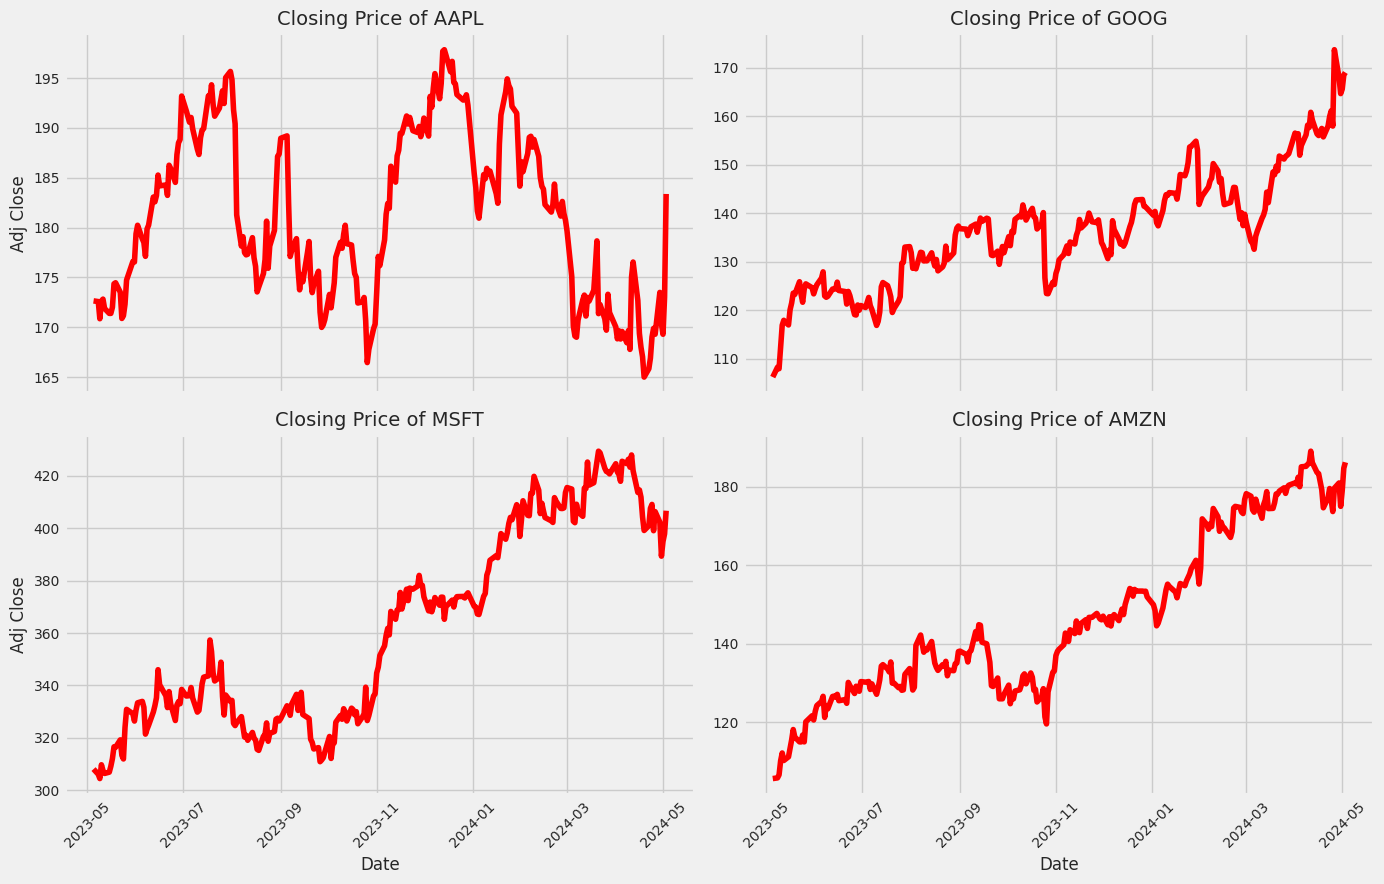

In [13]:
##### Exercise 3: Visualize the historical closing prices #####
# Define the figure size and layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 9), sharex=True)

# Loop through each company and subplot
for i, plt_confs in enumerate(zip(axes.flatten(), company_list, tech_list)):
    ax, company, name = plt_confs
    ax.plot(company['Adj Close'], color='red')
    ax.set_title(f'Closing Price of {name}')
    if i in (2, 3):
        ax.set_xlabel('Date')
    if i in (0, 2):
        ax.set_ylabel('Adj Close')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()
plt.show()

Volume refers to the number of shares traded during a certain period, often a day. It's a key metric for technical traders.
Let's visualize the daily trading volume for our list of companies.

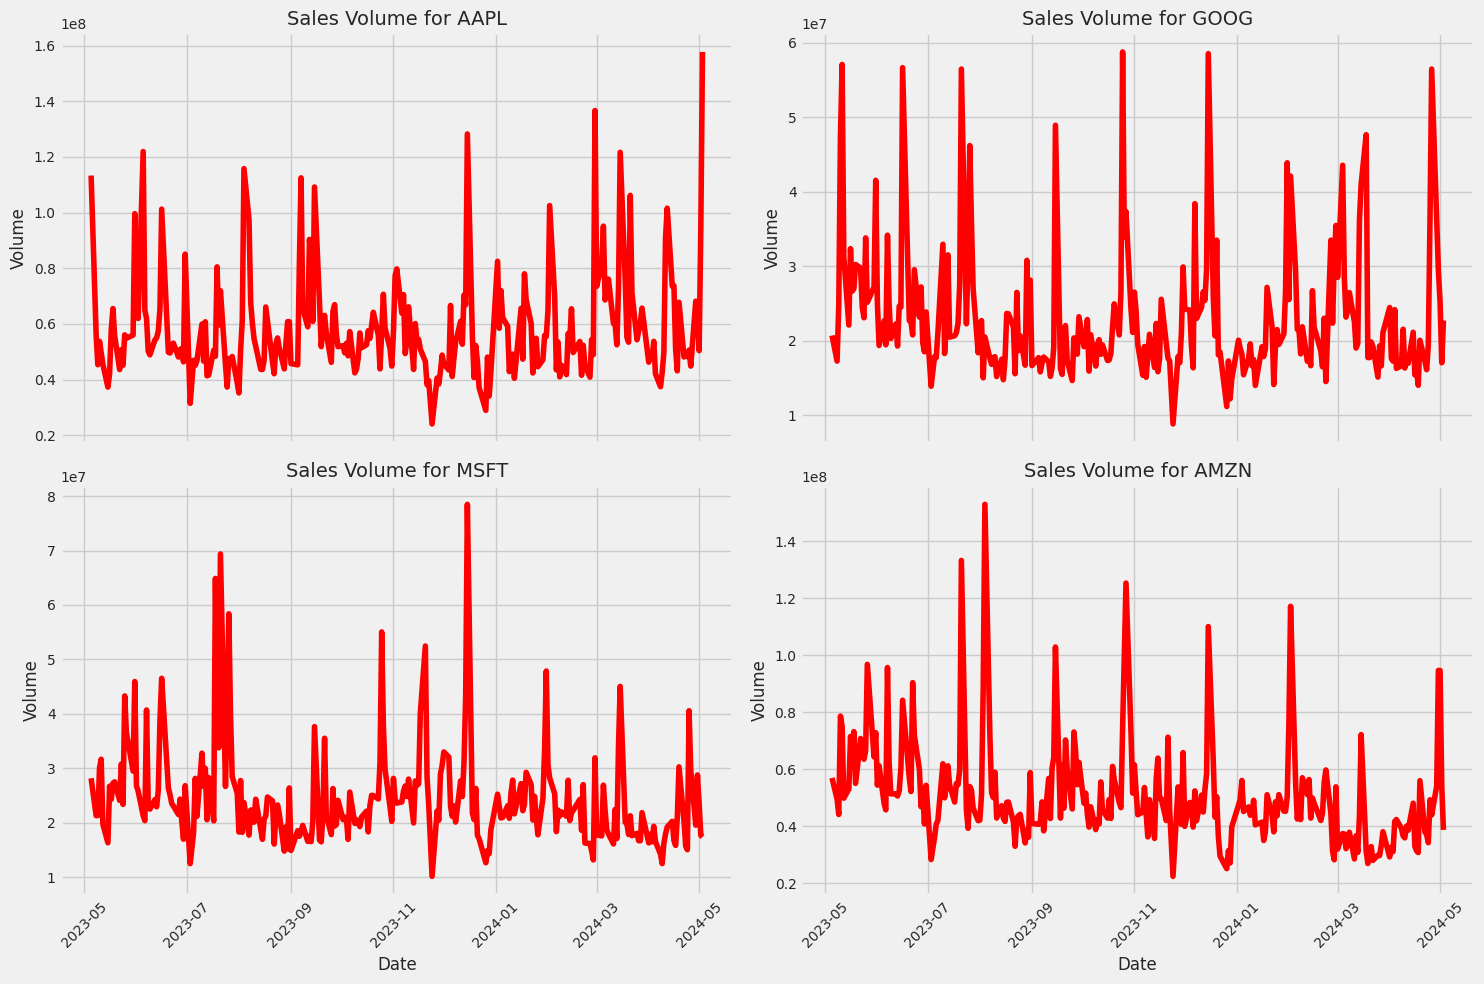

In [17]:
##### Exercise 4: Visualize the daily trading volume #####
##### Exercise 4: Visualize the daily trading volume #####

# Define the figure size and layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True)

# Loop through each company and subplot
for i, plt_confs in enumerate(zip(axes.flatten(), company_list, tech_list)):
    ax, company, name = plt_confs
    ax.plot(company['Volume'], color='red')
    ax.set_title(f'Sales Volume for {name}')
    if i in (2, 3):
        ax.set_xlabel('Date')
    ax.set_ylabel('Volume')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

A stock moving average (MA) is a widely used technical indicator in financial analysis that helps smooth out price trends by filtering out the noise from random short-term price fluctuations. It is calculated by taking the arithmetic mean of a given set of prices over a specified period.

The moving average can be of different types, such as Simple Moving Average (SMA) and Exponential Moving Average (EMA). SMA is calculated by taking the arithmetic mean of a given set of prices over a specified period. On the other hand, EMA places greater weight on more recent prices than older ones over the time period.

Here, you should calculate and plot the 10, 20, and 50-day moving averages along with the adjusted close price for each company. The moving averages are calculated using the `rolling` method, which applies a function (in this case, mean) to a rolling window of data. The plots provide a visual representation of the stock price trends over time.

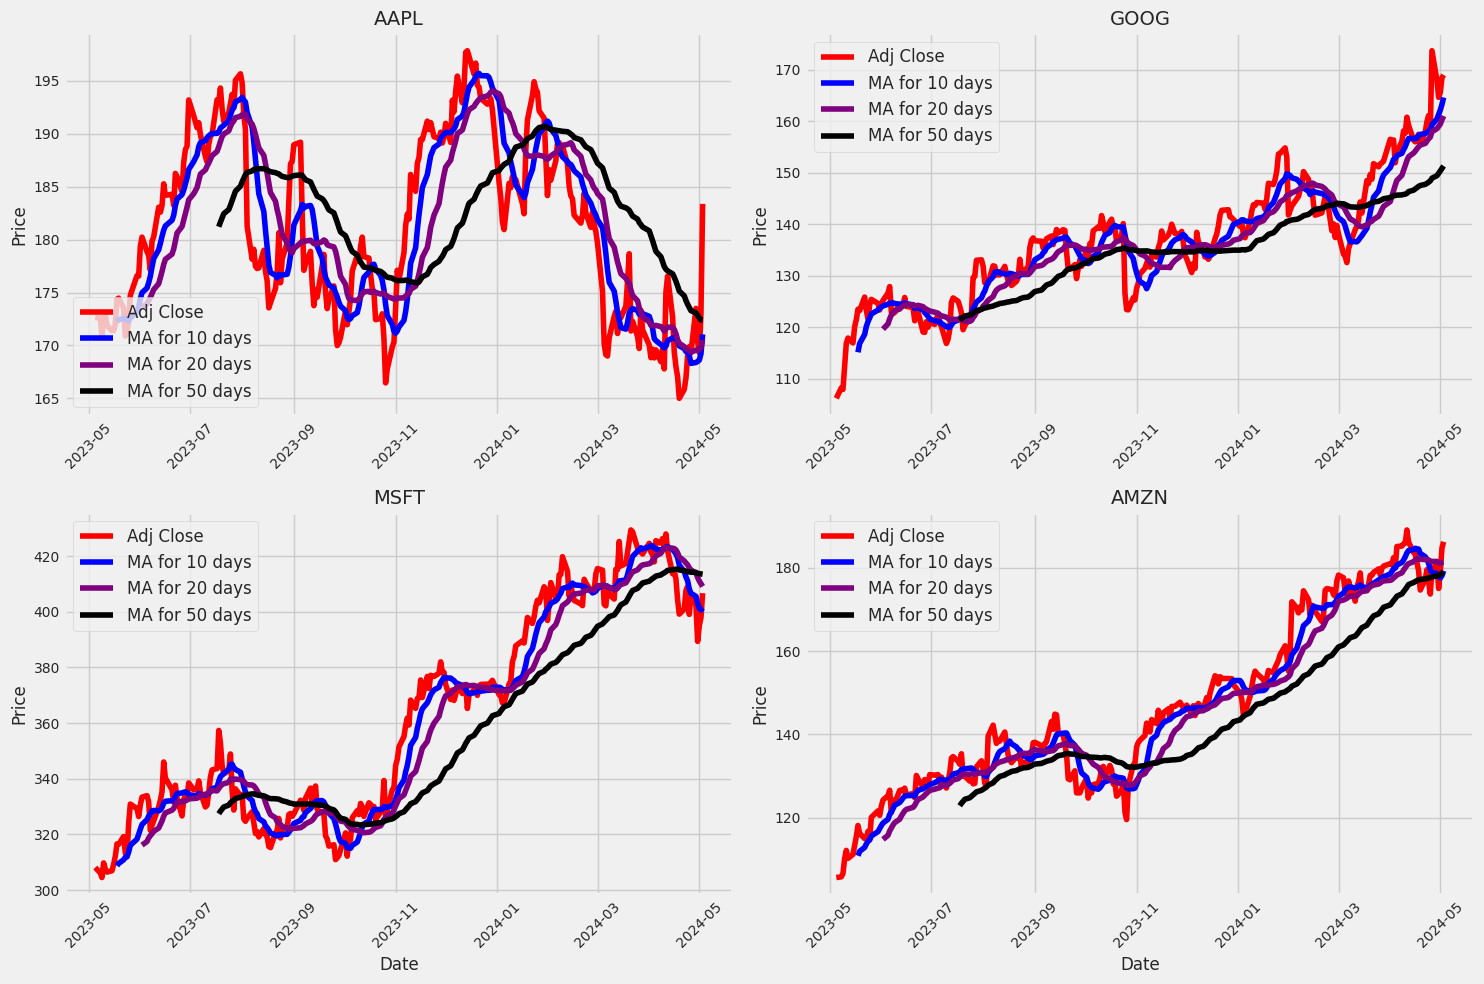

In [21]:
# Define moving average days
ma_day = [10, 20, 50]

##### Exercise 5: Calculate and plot the 10, 20, and 50-day moving averages along with the adjusted close price #####
# Define the figure size and layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Loop through each company and subplot
for i, plt_confs in enumerate(zip(axes.flatten(), company_list, tech_list)):
    ax, company, name = plt_confs
    company['MA for 10 days'] = company['Adj Close'].rolling(window=ma_day[0]).mean()
    company['MA for 20 days'] = company['Adj Close'].rolling(window=ma_day[1]).mean()
    company['MA for 50 days'] = company['Adj Close'].rolling(window=ma_day[2]).mean()

    ax.plot(company['Adj Close'], label='Adj Close', color='red')
    ax.plot(company['MA for 10 days'], label='MA for 10 days', color='blue')
    ax.plot(company['MA for 20 days'], label='MA for 20 days', color='purple')
    ax.plot(company['MA for 50 days'], label='MA for 50 days', color='black')

    ax.set_title(name)
    if i in (2, 3):
        ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.grid(True)
    ax.legend(loc='best')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Question:** Which moving average is the best choice for predicting the trends? Justify your answer.

**Your Answer:**

The choice of moving average (MA) depends on the specific goals and the context in which it is being used. Here's a breakdown of each type and their suitability:

1. **10-day Moving Average (Short-term)**:
   - This is a short-term moving average.
   - It responds quickly to recent price changes, making it useful for identifying short-term trends or changes in market sentiment.
   - It can be quite volatile, leading to more frequent false signals.

2. **20-day Moving Average (Medium-term)**:
   - This is a medium-term moving average.
   - It provides a balance between sensitivity and stability.
   - It captures medium-term trends effectively and is often used to indicate the general direction of the market over a few weeks.

3. **50-day Moving Average (Long-term)**:
   - This is a long-term moving average.
   - It smooths out short-term fluctuations, providing a clearer view of long-term trends.
   - It's less sensitive to short-term price changes, making it useful for identifying the overall market direction over a longer period.

**Which Moving Average is the Best Choice?**

The best moving average depends on the trader's objectives:

- **For short-term trading**, such as day trading or swing trading, the **10-day moving average** might be more suitable. It reacts quickly to price changes, helping traders capture short-term movements. However, it can also generate more false signals due to its sensitivity.

- **For medium-term trading**, such as position trading, the **20-day moving average** often provides a good balance. It responds quickly enough to capture trends while filtering out some of the noise associated with shorter time frames.

- **For long-term investing**, the **50-day moving average** is typically the best choice. It provides a smoother trend line, helping long-term investors identify the general direction of the market over a longer horizon.

**Justification:**

The choice should align with the time horizon of the trading or investment strategy:

- **Short-term Moving Averages** (e.g., 10-day) are best for capturing quick market shifts but come with higher volatility and noise.
- **Medium-term Moving Averages** (e.g., 20-day) strike a balance between sensitivity and stability, which is useful for medium-term trends.
- **Long-term Moving Averages** (e.g., 50-day) are useful for identifying long-term trends and are less prone to short-term market fluctuations.

Therefore, traders and investors should choose the moving average based on their specific trading style and the market context they are operating in.

Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve daily returns for all stocks. We'll use `pct_change` to find the percent change for each day.

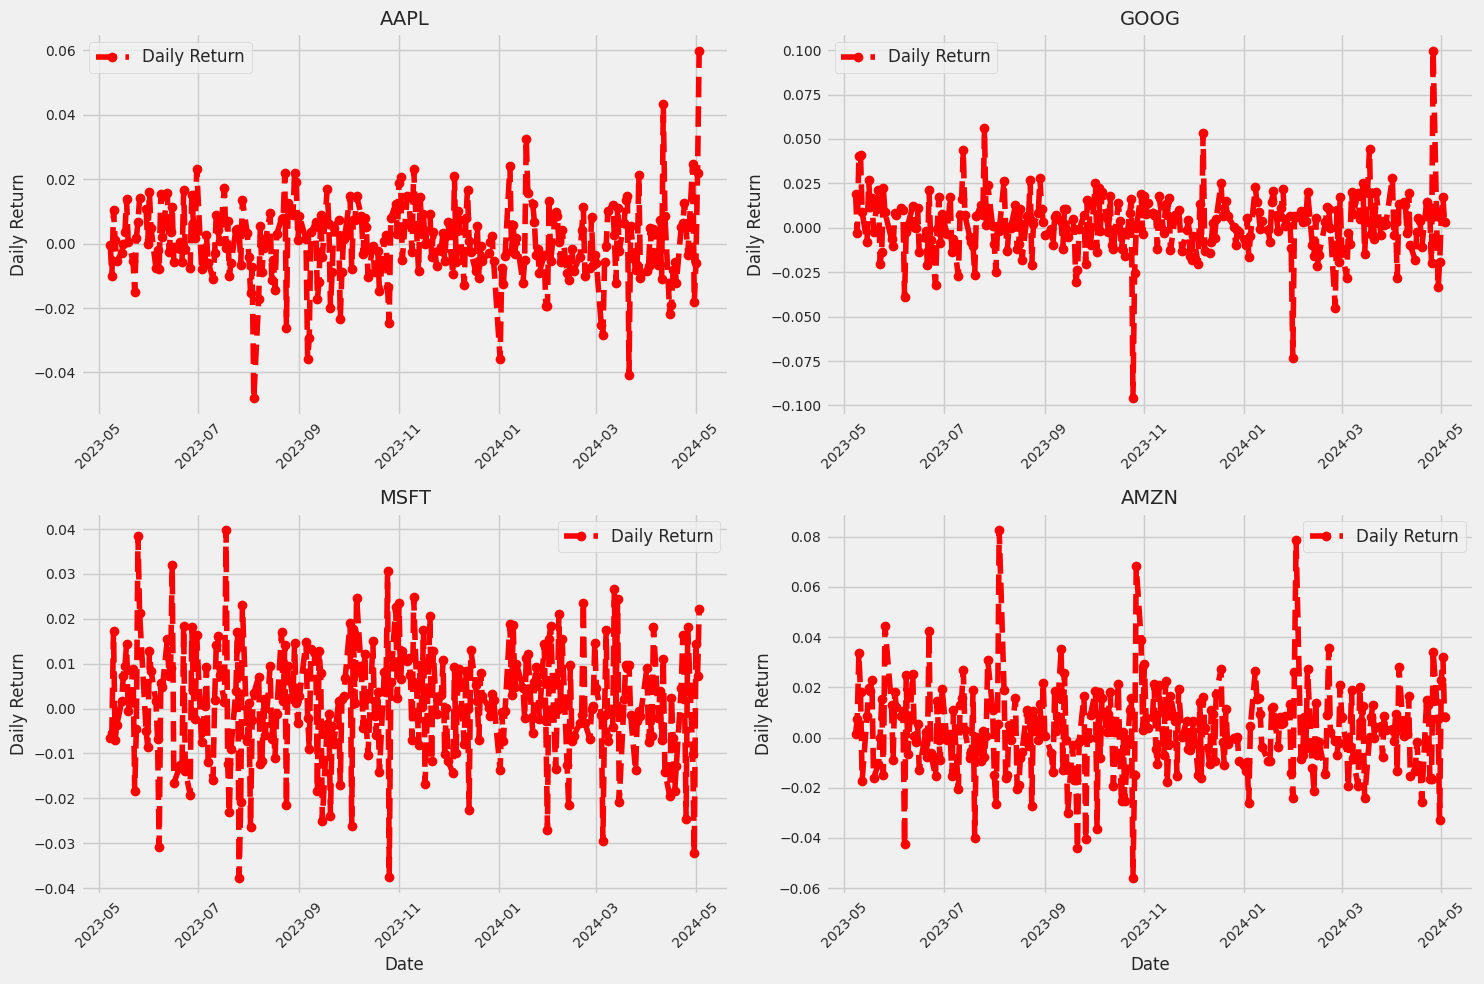

In [23]:
##### Exercise 6: Plot the daily return precentages #####
# Calculate daily returns
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Define the figure size and layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Loop through each company and subplot
for i, plt_confs in enumerate(zip(axes.flatten(), company_list, tech_list)):
    ax, company, name = plt_confs
    ax.plot(company['Daily Return'], label='Daily Return', linestyle='--', marker='o', color='red')
    ax.set_title(name)
    if i in (2, 3):
        ax.set_xlabel('Date')
    ax.set_ylabel('Daily Return')
    ax.grid(True)
    ax.legend(loc='best')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Now let's get an overall look at the daily returns by creating a histogram for the `Daily Return` of each company in the `company_list`.

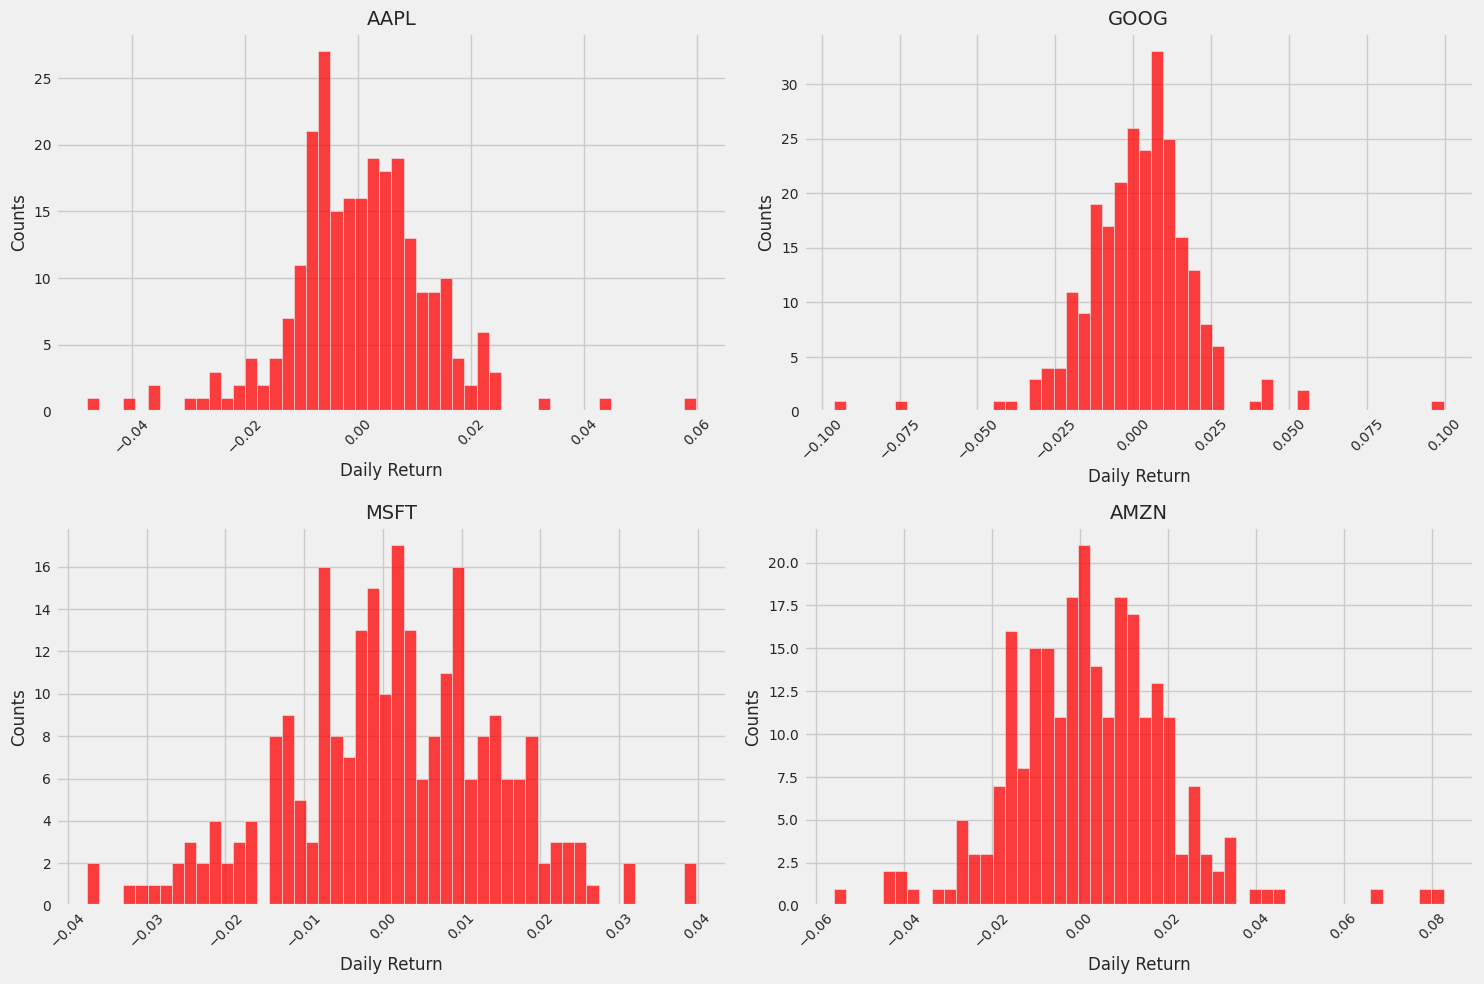

In [25]:
##### Exercise 7: Plot the histogram of Daily Returns #####
# Define the figure size and layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Loop through each company and subplot
for i, plt_confs in enumerate(zip(axes.flatten(), company_list, tech_list)):
    ax, company, name = plt_confs
    ax.hist(company['Daily Return'].dropna(), bins=50, color='red', alpha=0.75)
    ax.set_title(name)
    ax.set_xlabel('Daily Return')
    ax.set_ylabel('Counts')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Correlation between different stocks closing prices

Correlation is a statistical measure that quantifies the degree of relationship between two variables. It provides an indication of how changes in one variable are associated with changes in another. The correlation coefficient ranges between -1.0 and +1.0. A correlation of +1.0 indicates a perfect positive correlation, meaning that both variables move in the same direction together. A correlation of -1.0 indicates a perfect negative correlation, meaning that the variables move in opposite directions. If the correlation is 0, it means there is no relationship between the variables. However, it's important to note that correlation does not imply causation. Even if two variables are correlated, it does not mean that changes in one variable are causing changes in another. There could be a third factor influencing both variables.

In the context of stock analysis, suppose we are interested in examining the returns of all the stocks in our list. To facilitate this, we can construct a DataFrame that consolidates the `Adj Close` columns from each of the individual stock dataframes. This will provide us with a comprehensive view of the closing prices for all stocks, enabling more efficient comparative analysis.

In [26]:
# Get the closing prices for all stocks in the tech list
data = yf.download(tech_list, start=start, end=end)

# Select only the 'Adj Close' column for each stock
closing_df = data['Adj Close']

# Calculate the daily returns for each stock
tech_rets = closing_df.pct_change()

# Display the first few rows of the returns DataFrame
tech_rets.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-05-05,NaN,NaN,NaN,NaN
2023-05-08,-0.000403,0.001609,0.019065,-0.006438
2023-05-09,-0.009971,0.007465,-0.002772,-0.005346
2023-05-10,0.010421,0.033483,0.040207,0.017296
2023-05-11,0.001095,0.018060,0.041147,-0.007044


Now we can compare the daily percentage return of all pairs to check how they are correlated.

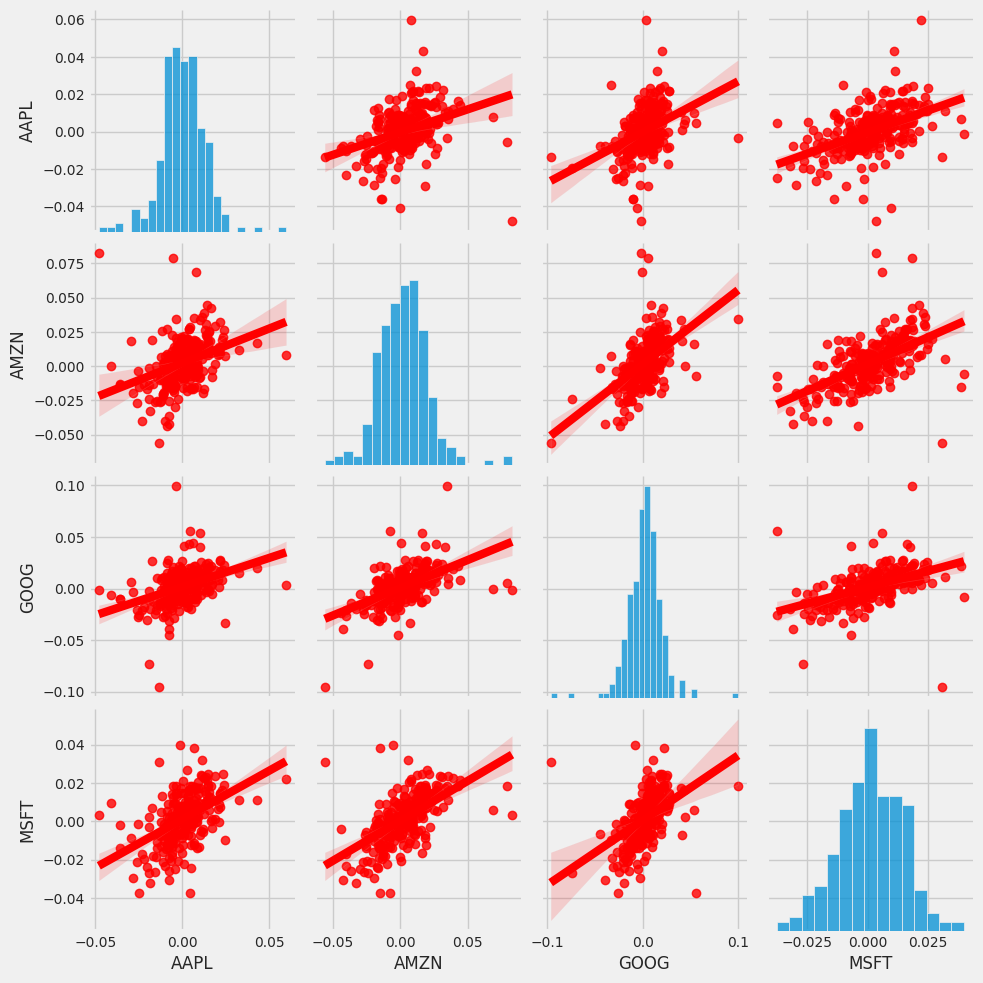

In [28]:
##### Exercise 8: Plot the correlation regression plot for all pairs #####
# Use Seaborn's pairplot function to plot the regression plots
sns.pairplot(tech_rets, kind='reg', diag_kind='hist', plot_kws={'color': 'red'})

# Display the plot
plt.show()

**Question:** What implications might a linear relationship have for investment strategies?

**Your Answer:**

A linear relationship between stock returns implies that changes in one stock's price are directly related to changes in another stock's price. For investment strategies, this can have several implications:

1. **Diversification**: If two stocks have a strong positive correlation, investing in both may not effectively diversify risk. Conversely, negative or low correlations can help reduce portfolio volatility.

2. **Hedging**: A negative correlation can be useful for hedging, where one stock's gain can offset another's loss.

3. **Pairs Trading**: If two stocks move similarly, pairs trading strategies can exploit temporary divergences in their prices.

4. **Market Timing**: Understanding correlations can help investors anticipate how stocks might react to market events or trends, enhancing market timing strategies.

Finally, Let's create two heatmaps: one for the correlation between the daily returns of the stocks and another for the correlation between the closing prices of the stocks. This provides a visual and numerical understanding of the relationships between different stocks.

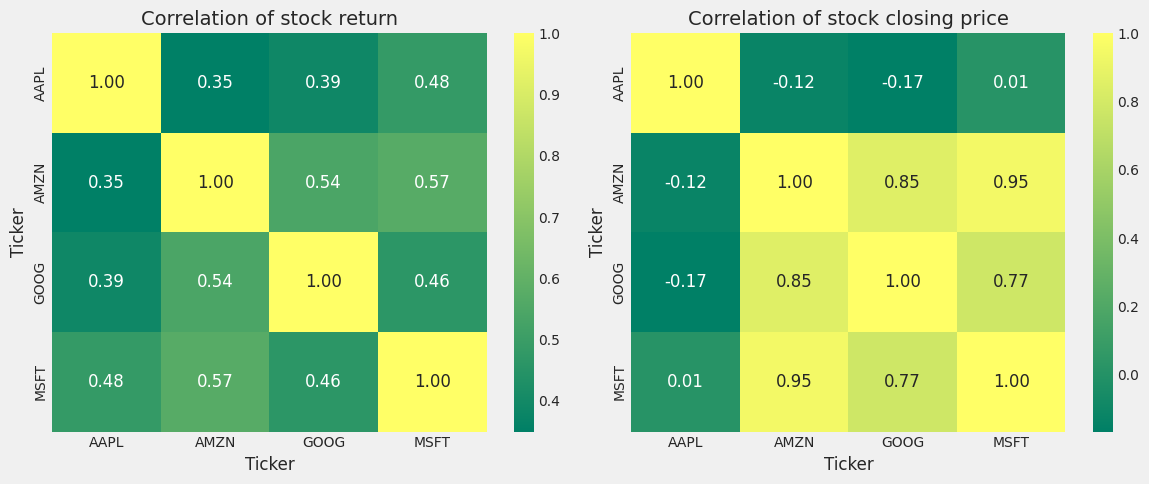

In [31]:
##### Exercise 9: Plot correlation heatmaps #####
# Compute the correlation for daily returns
returns_corr = tech_rets.corr()

# Compute the correlation for closing prices
price_corr = closing_df.corr()

# Create a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# Plot the daily returns correlation heatmap
sns.heatmap(returns_corr, annot=True, fmt=".2f", cmap="summer", ax=axes[0])
axes[0].set_title("Correlation of stock return")
axes[0].set_xlabel("Ticker")
axes[0].set_ylabel("Ticker")

# Plot the closing prices correlation heatmap
sns.heatmap(price_corr, annot=True, fmt=".2f", cmap="summer", ax=axes[1])
axes[1].set_title("Correlation of stock closing price")
axes[1].set_xlabel("Ticker")
axes[1].set_ylabel("Ticker")

plt.tight_layout()
plt.show()

**Question:** Which pair has the strongest correlation of daily return stocks? What other interesting facts could be infered from the plots above?

**Your Answer:**

- **Strongest Correlation of Daily Return:** AMZN and MSFT, with a correlation of 0.55.
- **Interesting Facts:** The correlation of closing prices between AMZN and MSFT is also very high (0.95). Additionally, the closing prices show stronger correlations overall compared to the daily returns, indicating more synchronous longer-term trends among the stocks.

# Predicting the closing price
In this section, we will try to predict the closing price of a stock using an LSTM model. Choose one stock and after visualizing the closing history, do any preprocessing you need and create a training data set.

In [32]:
##### Exercise 10: Download and display the head of a stock from Yahoo Finance (start='2012-01-01') #####

# Choose a stock to analyze, let's select Apple (AAPL)
stock_ticker = 'AAPL'

# Download the stock data from Yahoo Finance
stock_data = yf.download(stock_ticker, start='2012-01-01')

# Display the head of the stock data
stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433826,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500646,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639427,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771559,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751298,394024400


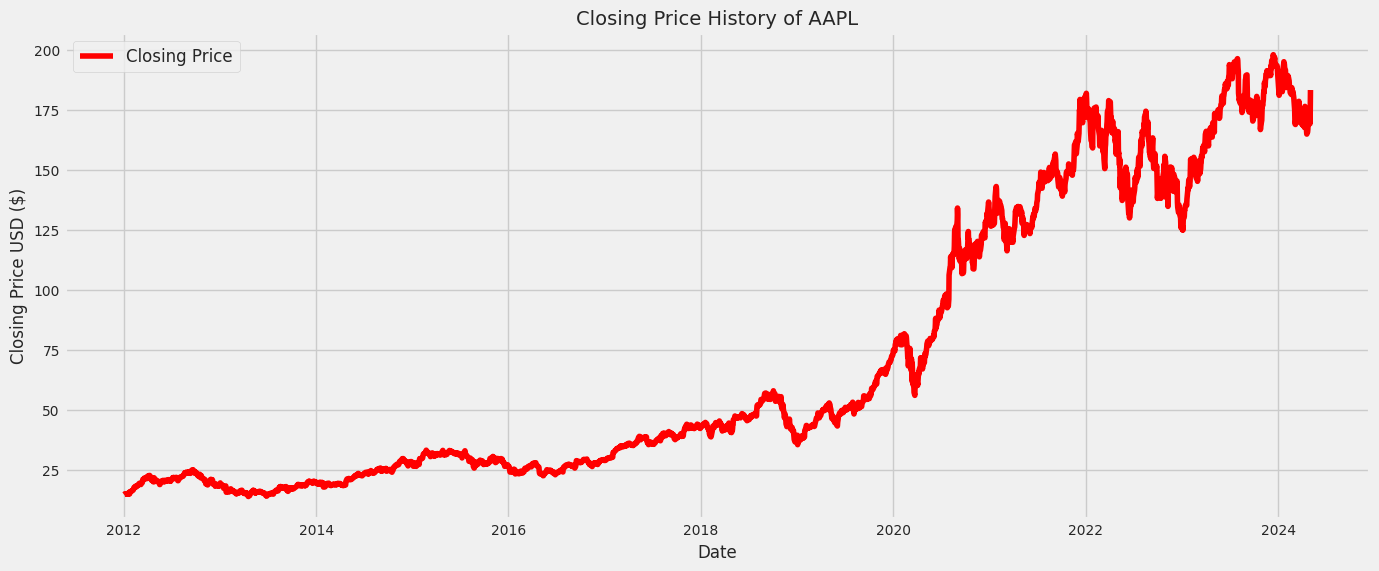

In [35]:
##### Exercise 11: Plot the closing price history of your stock #####
# Plot the closing price
plt.figure(figsize=(15, 6))
plt.plot(stock_data['Close'], label='Closing Price', color='red')
plt.title(f'Closing Price History of {stock_ticker}')
plt.xlabel('Date')
plt.ylabel('Closing Price USD ($)')
plt.legend()
plt.grid(True)
plt.show()

In [96]:
##### Exercise 12: Preparing the data (Use a 95-5 Train/Test ratio) #####
# Get the closing prices
closing_prices = stock_data['Close'].values

# Determine the split index for a 95-5 ratio
train_size = int(len(closing_prices) * 0.95)
test_size = len(closing_prices) - train_size

# Split the data
window_size = 60
train_data = closing_prices[:train_size]
test_data = closing_prices[train_size - window_size:]

print(f"Number of Training data points: {len(train_data)}")
print(f"Number of Testing data points: {len(test_data)}")

Number of Training data points: 2948
Number of Testing data points: 216


In [97]:
from sklearn.preprocessing import MinMaxScaler

##### Exercise 13: Scaling the data #####

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape and scale the training data
train_data = train_data.reshape(-1, 1)
scaled_train_data = scaler.fit_transform(train_data)

print(scaled_train_data)

[[0.00405082]
 [0.0044833 ]
 [0.00538153]
 ...
 [0.89874113]
 [0.90476848]
 [0.8851523 ]]


In [98]:
##### Exercise 14: Creating the training and test data sets #####
# Define window size
window_size = 60

# Creating the training data set
x_train, y_train = [], []

for i in range(window_size, len(scaled_train_data)):
    x_train.append(scaled_train_data[i - window_size:i, 0])
    y_train.append(scaled_train_data[i, 0])

# Convert training data to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Creating the test data set
scaled_test_data = scaler.transform(test_data.reshape(-1, 1))

x_test, y_test = [], []

for i in range(window_size, len(scaled_test_data)):
    x_test.append(scaled_test_data[i - window_size:i, 0])
    y_test.append(scaled_test_data[i, 0])

# Convert test data to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape for LSTM input
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Convert to torch tensors
x_train_tensors = torch.from_numpy(x_train.astype(np.float32))
y_train_tensors = torch.from_numpy(y_train.astype(np.float32))
x_test_tensors = torch.from_numpy(x_test.astype(np.float32))
y_test_tensors = torch.from_numpy(y_test.astype(np.float32))

# Output the shapes of the training and testing data
print(f"x_train shape: {x_train_tensors.shape}")
print(f"y_train shape: {y_train_tensors.shape}")
print(f"x_test shape: {x_test_tensors.shape}")
print(f"y_test shape: {y_test_tensors.shape}")

x_train shape: torch.Size([2888, 60, 1])
y_train shape: torch.Size([2888])
x_test shape: torch.Size([156, 60, 1])
y_test shape: torch.Size([156])


Define your model here. Feel free to add/change variables or parameters to suit your needs.


In [113]:
##### Exercise 15: Define your model ######
# LSTM Model
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers, output_size):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.fc(out[:, -1, :])
        return out

# Set Hyper-parameters
num_epochs = 1000
learning_rate = 0.00005

input_size = 1
hidden_size1 = 50
hidden_size2 = 50
num_layers = 1
seq_length = 60
output_size = 1

lstm = LSTM(input_size, hidden_size1, hidden_size2, num_layers, output_size)

# Loss and Optimizer
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [114]:
##### Exercise 16: Train the model #####
# Choose the device (CPU or GPU) based on availability
# This allows the model to use GPU acceleration if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lstm = lstm.to(device)
lstm.train()

# Train the model
for epoch in range(num_epochs):
    optimizer.zero_grad()
    # Forward pass
    outputs = lstm(x_train_tensors.to(device))
    loss = criterion(outputs.squeeze(), y_train_tensors.to(device))

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, loss: {loss.item():.5f}")

Epoch: 0, loss: 0.11668
Epoch: 10, loss: 0.11202
Epoch: 20, loss: 0.10773
Epoch: 30, loss: 0.10380
Epoch: 40, loss: 0.10024
Epoch: 50, loss: 0.09703
Epoch: 60, loss: 0.09414
Epoch: 70, loss: 0.09155
Epoch: 80, loss: 0.08924
Epoch: 90, loss: 0.08718
Epoch: 100, loss: 0.08534
Epoch: 110, loss: 0.08370
Epoch: 120, loss: 0.08223
Epoch: 130, loss: 0.08090
Epoch: 140, loss: 0.07967
Epoch: 150, loss: 0.07851
Epoch: 160, loss: 0.07737
Epoch: 170, loss: 0.07623
Epoch: 180, loss: 0.07504
Epoch: 190, loss: 0.07377
Epoch: 200, loss: 0.07239
Epoch: 210, loss: 0.07086
Epoch: 220, loss: 0.06915
Epoch: 230, loss: 0.06720
Epoch: 240, loss: 0.06495
Epoch: 250, loss: 0.06232
Epoch: 260, loss: 0.05920
Epoch: 270, loss: 0.05542
Epoch: 280, loss: 0.05079
Epoch: 290, loss: 0.04500
Epoch: 300, loss: 0.03774
Epoch: 310, loss: 0.02887
Epoch: 320, loss: 0.01929
Epoch: 330, loss: 0.01143
Epoch: 340, loss: 0.00704
Epoch: 350, loss: 0.00546
Epoch: 360, loss: 0.00485
Epoch: 370, loss: 0.00436
Epoch: 380, loss: 0.003

In [116]:
##### Exercise 17: Predict price values & Calcualte RMSE for Test set ######
# Make predictions on the test set
lstm.eval()
with torch.no_grad():
    predicted_test = lstm(x_test_tensors.to(device))

# Convert the predictions back to the original scale
predicted_test_act = scaler.inverse_transform(predicted_test.detach().cpu().numpy())

# Calculate RMSE
rmse = np.sqrt(np.mean((predicted_test.detach().cpu().numpy() - np.expand_dims(y_test, axis=0)) ** 2))
print(f"RMSE Norm: {rmse:.10f}")

rmse_act = np.sqrt(np.mean((predicted_test_act - scaler.inverse_transform(np.expand_dims(y_test, axis=0))) ** 2))
print(f"RMSE Actual: {rmse_act:.10f}")

RMSE Norm: 0.0654794650
RMSE Actual: 11.9501688354


In [ ]:
predicted_test

In [ ]:
len(train_data) - window_size

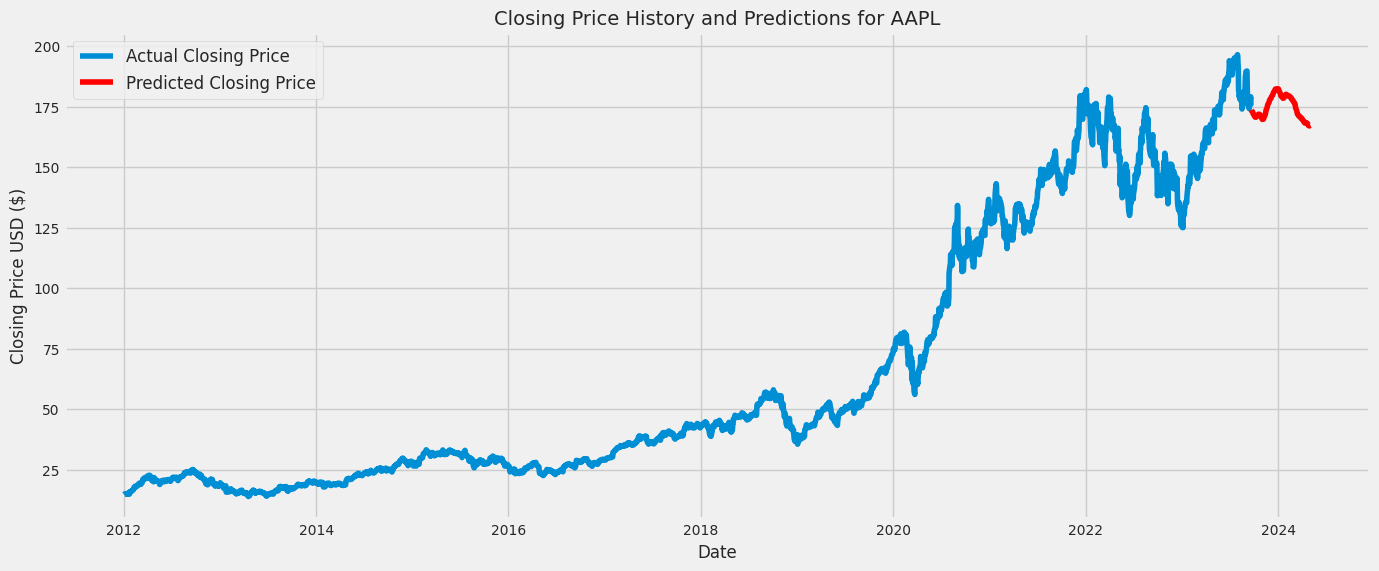

In [119]:
##### Exercise 18: Plot the entire closing price history & Compare it to your predictions ######
# Plot the closing price history and predictions
plt.figure(figsize=(15, 6))
plt.plot(stock_data['Close'][:len(train_data)], label='Actual Closing Price')
plt.plot(stock_data.index[len(train_data):], predicted_test_act.flatten(), label='Predicted Closing Price', color='red')
plt.title(f'Closing Price History and Predictions for {stock_ticker}')
plt.xlabel('Date')
plt.ylabel('Closing Price USD ($)')
plt.legend()
plt.grid(True)
plt.show()

In [123]:
# Show the valid and predicted prices
gt_df = stock_data['Close'][len(train_data):].to_frame()
gt_df['Predictions'] = predicted_test_act.flatten()

gt_df

,Close,Predictions
Date,,
2023-09-21,173.929993,173.568207
2023-09-22,174.789993,173.314865
2023-09-25,176.080002,173.060120
2023-09-26,171.960007,172.842819
2023-09-27,170.429993,172.565277
...,...,...
2024-04-29,173.500000,167.033936
2024-04-30,170.330002,167.076111
2024-05-01,169.300003,167.122101


## **Bonus**

You have the opportunity to develop an autoregressive model based on the concepts you learned in class and subsequently train it. Following that, you can compare its performance with that of the LSTM model

In [ ]:
##### Bonus ######

**If you have any questions or need further clarification on any part of the exercise, please don’t hesitate to ask.**